In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn.nc")
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      eta_u: 600, xi_u: 799, eta_v: 599, xi_v: 800,
                      eta_psi: 599, xi_psi: 799)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    lat_u            (eta_u, xi_u) float64 ...
    lat_v            (eta_v, xi_v) float64 ...
    lon_psi          (eta_psi, xi_psi) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    lon_u            (eta_u, xi_u) float64 ...
    lon_v            (eta_v, xi_v) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [3]:
# do special processing for ROMS formatting
ds['hc']=20


def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])


    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi
    
    
    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds


# if loading a multi-file dataset, then process the grid with this.
ds = processROMSGrid(ds)

In [4]:
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut

grid = makeROMSGridObject(ds)

In [5]:
#for 
ds=ds.set_coords(("lon_rho","lat_rho"))

In [6]:
# drop some variables to speed up loading!
ds = ds[['u_eastward','v_northward','z_rho0']]
ds = ds.drop(['z_rho'])

# Let's load the u,v velocities to speed this up...
ds.load()

<xarray.Dataset>
Dimensions:      (ocean_time: 73, s_rho: 31, eta_rho: 600, xi_rho: 800)
Coordinates:
    z_rho0       (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... -0.8484 -0.2858
  * ocean_time   (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho        (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
    lat_rho      (eta_rho, xi_rho) float64 -30.0 -30.0 -30.0 ... -24.01 -24.01
    lon_rho      (eta_rho, xi_rho) float64 151.5 151.5 151.5 ... 159.5 159.5
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    u_eastward   (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 0.0
    v_northward  (ocean_time, s_rho, eta_rho, xi_rho) float32 nan nan ... 0.0
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [7]:
u_bar = ds.u_eastward.mean("ocean_time")
v_bar = ds.v_northward.mean("ocean_time")
mke = 0.5*(u_bar**2 + v_bar**2)

ds["mke"] = mke

In [8]:
u_bar = ds.u_eastward.mean("ocean_time")
v_bar = ds.v_northward.mean("ocean_time")

print('calc velocity anomalies')
u_prime = ds.u_eastward - u_bar
v_prime = ds.v_northward - v_bar

print('calc eke')
eke = 0.5*(u_prime**2 + v_prime**2)

ds["eke"] = eke

calc velocity anomalies
calc eke


<Figure size 640x480 with 0 Axes>

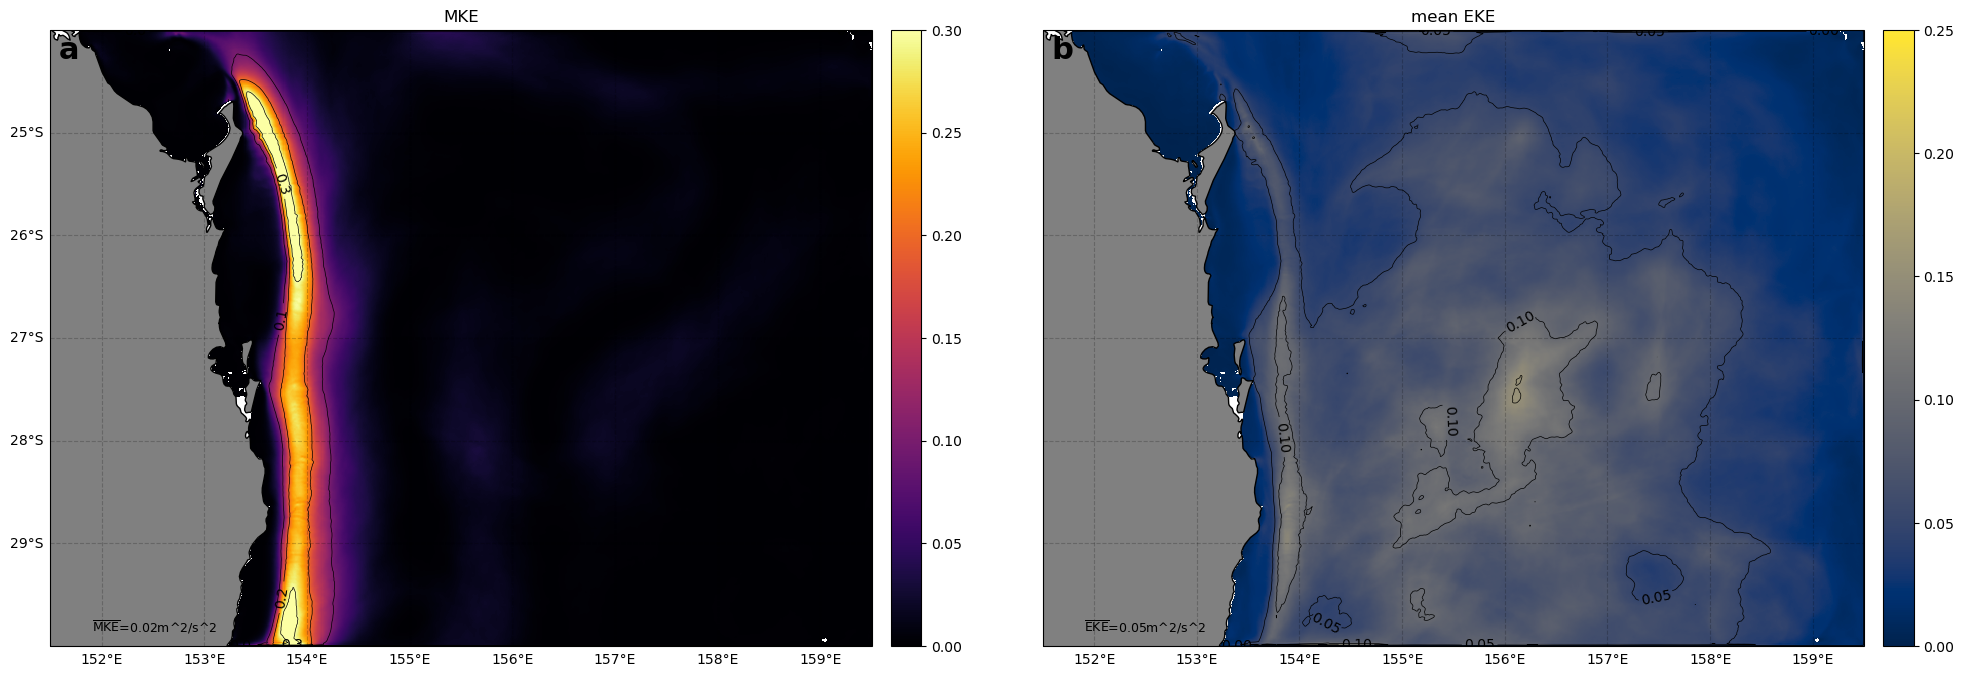

In [10]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[25,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),vmin=0,vmax=.3,cmap='inferno')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),colors='k',levels=np.arange(0,.6,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('MKE')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .03,  '$\overline{\mathrm{MKE}}$='+str(grid.average((ds.mke.isel(s_rho=-1)),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)

fig.colorbar(im,fraction=0.04, pad=0.02)

ax=fig.add_subplot(gs[0,1],projection=ccrs.PlateCarree())
ax.set_extent([151.5, 159.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-1).mean(dim='ocean_time'),vmin=0,vmax=.25,cmap='cividis')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-1).mean(dim='ocean_time'),colors='k',levels=np.arange(0,.3,.05),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('mean EKE')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .03,  '$\overline{\mathrm{EKE}}$='+str(grid.average((ds.eke.isel(s_rho=-1).mean(dim='ocean_time')),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)

fig.colorbar(im,fraction=0.04, pad=0.02)

<Figure size 640x480 with 0 Axes>

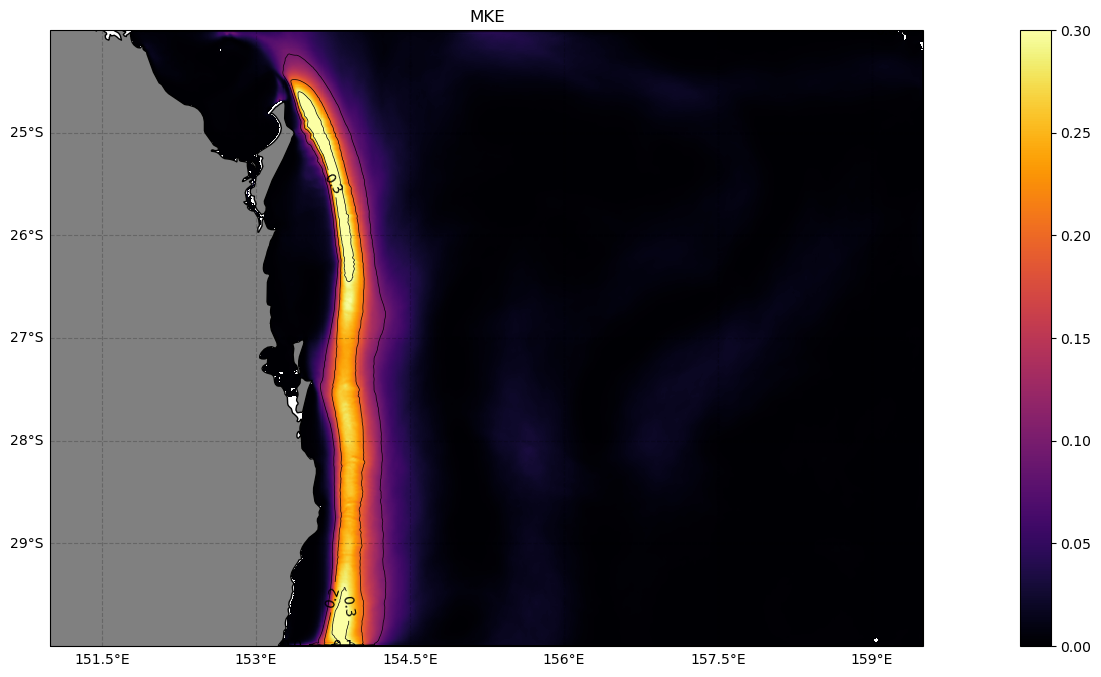

In [10]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[25,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([151, 159.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im = ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),vmin=0,vmax=.3,cmap='inferno')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.mke.isel(s_rho=-1),colors='k',levels=np.arange(0,.6,.1),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('MKE')
#ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
#ax.text(.05, .03,  '$\overline{\mathrm{MKE}}$='+str(grid.average((ds.mke.isel(s_rho=-1)),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)

fig.colorbar(im)

<Figure size 640x480 with 0 Axes>

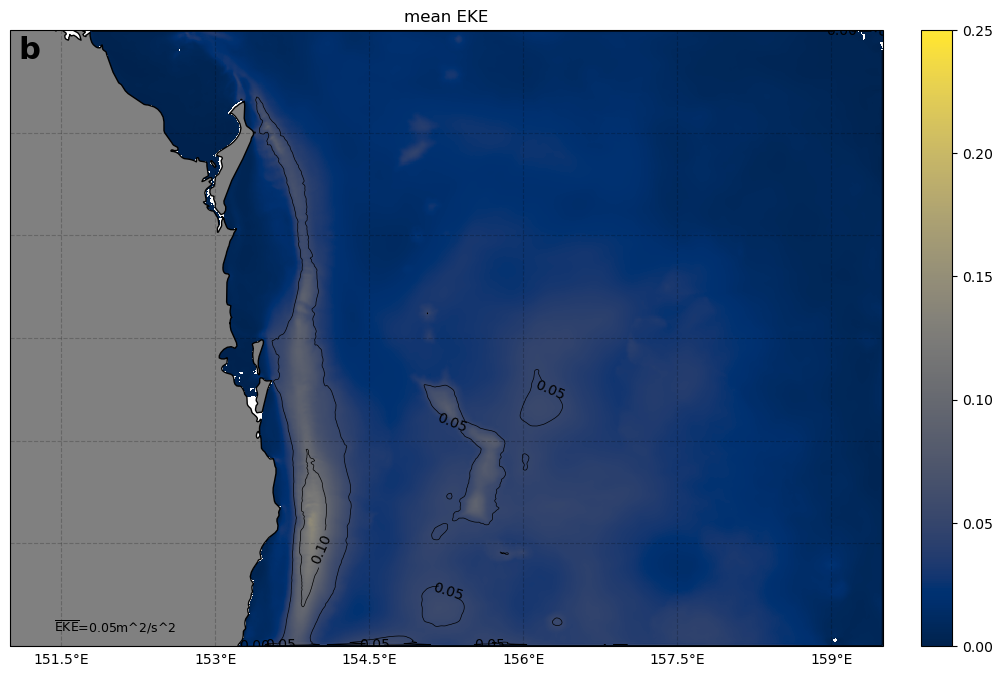

In [11]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[25,8])
ax = None

ax=fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree())
ax.set_extent([151, 159.5, -30, -24])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray', label='_nolegend_')
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-10).mean(dim='ocean_time'),vmin=0,vmax=.25,cmap='cividis')
co=ax.contour(ds.lon_rho,ds.lat_rho,ds.eke.isel(s_rho=-10).mean(dim='ocean_time'),colors='k',levels=np.arange(0,.3,.05),linewidths=0.5)
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
ax.clabel(co,inline=True)
ax.set_title('mean EKE')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.text(.05, .03,  '$\overline{\mathrm{EKE}}$='+str(grid.average((ds.eke.isel(s_rho=-1).mean(dim='ocean_time')),['X','Y']).round(2).values)+'m^2/s^2',fontsize=9, va='center', ha='left', transform=ax.transAxes)

fig.colorbar(im,fraction=0.04, pad=0.02)

<Figure size 640x480 with 0 Axes>

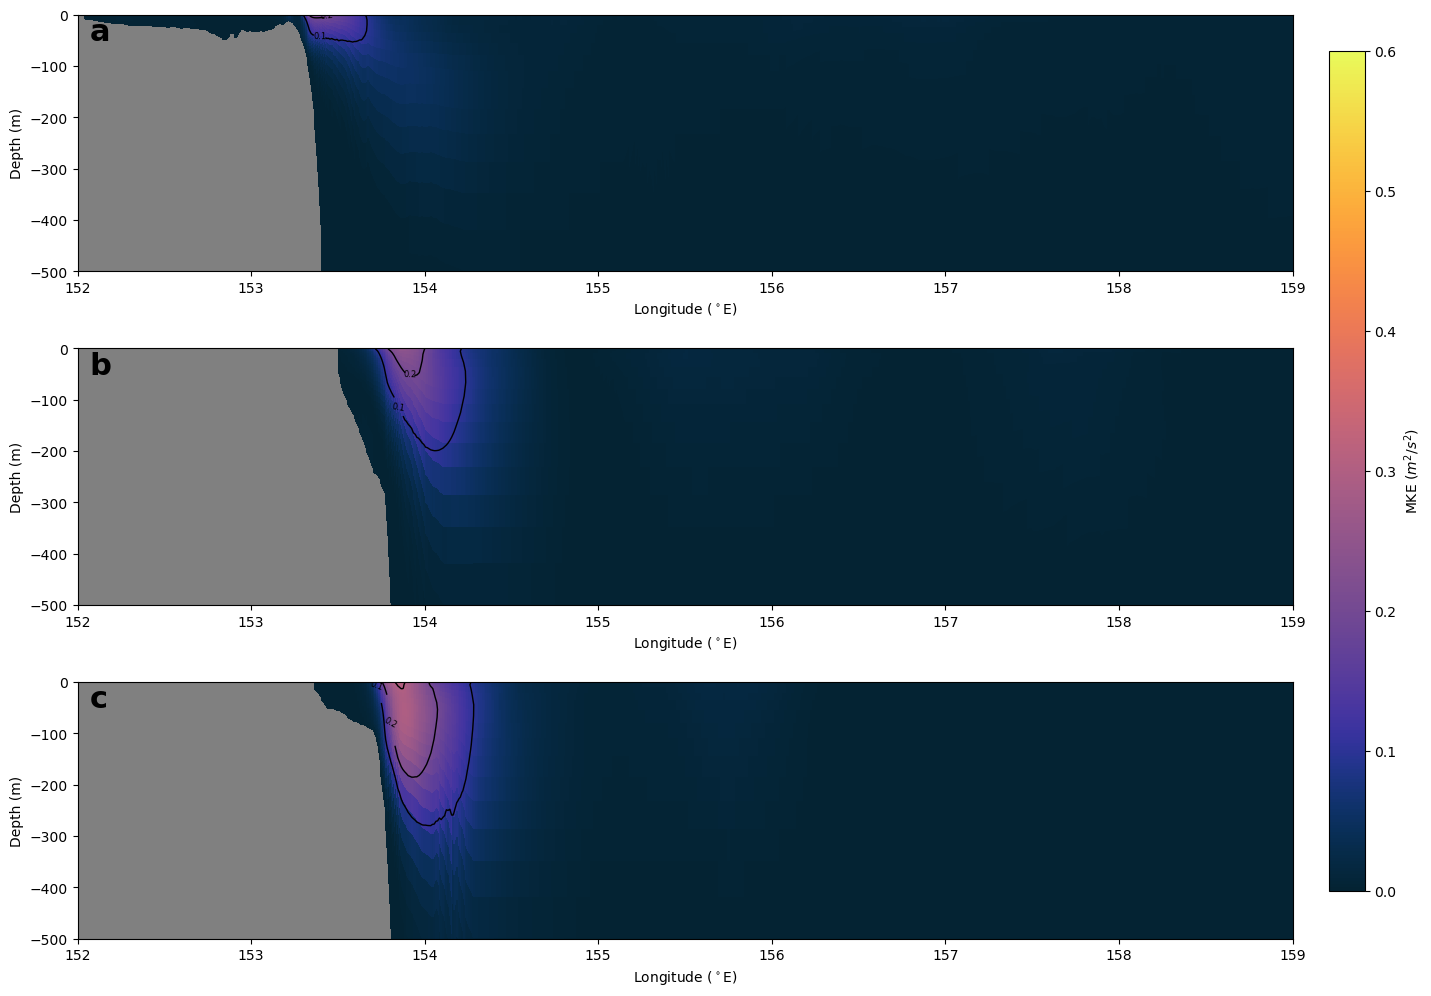

In [9]:
section1=ds.isel(eta_rho=550,xi_rho=slice(50,750))
section2=ds.isel(eta_rho=300,xi_rho=slice(200,750))
section3=ds.isel(eta_rho=50,xi_rho=slice(180,750))

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,12])


ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section1.mke.plot(y='z_rho0',x='lon_rho',cmap='cmo.thermal',add_colorbar=False,vmin=0,vmax=.6)
co1 = section1.mke.plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.6,.1),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# 

ax = fig.add_subplot(gs[1,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section2.mke.plot(y='z_rho0',x='lon_rho',cmap='cmo.thermal',add_colorbar=False,vmin=0,vmax=.6)
co1 = section2.mke.plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.6,.1),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section3.mke.plot(y='z_rho0',x='lon_rho',cmap='cmo.thermal',add_colorbar=False,vmin=0,vmax=.6)
co1 = section3.mke.plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.6,.1),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

#cax.yaxis.tick_left()
#cax.set_ylabel('MKE')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('MKE ($m^2/s^2$)')

<Figure size 640x480 with 0 Axes>

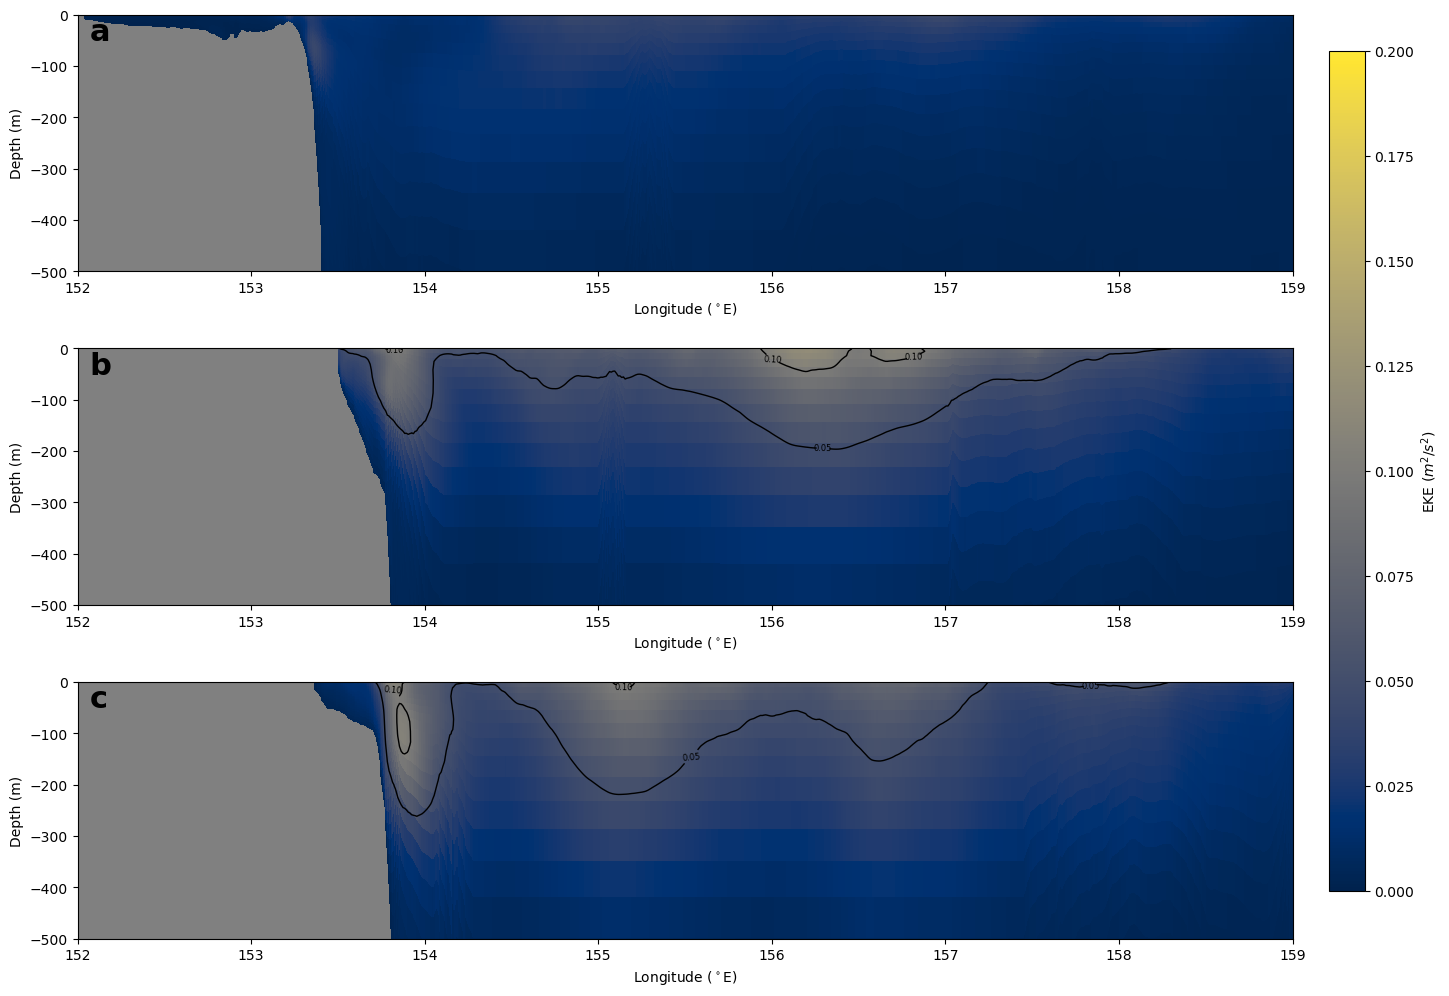

: 

In [10]:
section1=ds.isel(eta_rho=550,xi_rho=slice(50,750))
section2=ds.isel(eta_rho=300,xi_rho=slice(200,750))
section3=ds.isel(eta_rho=50,xi_rho=slice(180,750))

gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,12])

ax = fig.add_subplot(gs[0,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section1.eke.mean(dim="ocean_time").plot(y='z_rho0',x='lon_rho',cmap='cividis',add_colorbar=False,vmin=0,vmax=.2)
co1 = section1.eke.mean(dim="ocean_time").plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.3,.05),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# 

ax = fig.add_subplot(gs[1,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section2.eke.mean(dim="ocean_time").plot(y='z_rho0',x='lon_rho',cmap='cividis',add_colorbar=False,vmin=0,vmax=.2)
co1 = section2.eke.mean(dim="ocean_time").plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.3,.05),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[2,0])#, projection=ccrs.PlateCarree())
ax.set_facecolor('gray')
im = section3.eke.mean(dim="ocean_time").plot(y='z_rho0',x='lon_rho',cmap='cividis',add_colorbar=False,vmin=0,vmax=.2)
co1 = section3.eke.mean(dim="ocean_time").plot.contour(y='z_rho0',x='lon_rho',colors='k',linewidths=1,levels=np.arange(0,.3,.05),linestyles='-')
plt.clabel(co1,fontsize=6,inline_spacing=0,inline=True)
ax.set_title('')
#ax.set_xlim((153,159.3))
ax.set_ylim((-500,0))
plt.xlim(152,159)
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Longitude ($^\circ$E)')
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
 
#cax.yaxis.tick_left()
#cax.set_ylabel('MKE')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
cbar=fig.colorbar(im, cax=cbar_ax)
cbar.set_label('EKE ($m^2/s^2$)')